In [1]:
import sys
import matplotlib.pyplot as plt

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


In [2]:
!pip install networkx

In [3]:
import pandas as pd
from glob import glob
import os
import kagglehub
import numpy as np
import datetime
import re
import networkx as nx
# Download latest version
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")

path_lists = glob(path + '/*.csv')

# 파일명을 기준으로 변수명 설정 및 DataFrame 로딩
loaded_dfs = {}
for file_path in path_lists:
    file_name = os.path.basename(file_path).replace('.csv', '')  # 확장자 제거
    var_name = file_name.lower()  # 변수명 통일
    loaded_dfs[var_name] = pd.read_csv(file_path)

# 변수 직접 지정 (원하시는 변수명을 그대로 사용)
item_1 = loaded_dfs.get('item_properties_part1')
item_2 = loaded_dfs.get('item_properties_part2')
events = loaded_dfs.get('events')
category_tree = loaded_dfs.get('category_tree')



# 2. item_properties 전처리
item = pd.concat([item_1, item_2])
item = item[item.property.isin(["categoryid", "790"])]
item = item[item.itemid.isin(events.itemid.unique())]
item["value"] = item["value"].str.replace("n", "", regex=False)
item["value"] = pd.to_numeric(item["value"], errors="coerce")
item["property"] = item["property"].map({"790": "price", "categoryid": "categoryid"})

# 3. 가격/카테고리 유효기간 계산
item = item.sort_values("timestamp")
item["lag_value"] = item.groupby(["itemid", "property"])["value"].shift(1)
item["lead_timestamp"] = item.groupby(["itemid", "property"])["timestamp"].shift(-1)
item["is_change"] = item.lag_value.isna() | (item.lag_value != item.value)
item = item[item["is_change"]]
item["lead_timestamp"].fillna(item.timestamp.max(), inplace=True)
item.rename(columns={"timestamp": "valid_start", "lead_timestamp": "valid_end"}, inplace=True)
item["time_valid"] = item["valid_end"] - item["valid_start"]

# 4. events와 item 속성 조인
events = events[events.itemid.isin(item.itemid.unique())]
events_enh = events.merge(item, on="itemid")
events_enh = events_enh[
    (events_enh.timestamp >= events_enh.valid_start) &
    (events_enh.timestamp < events_enh.valid_end)
]
events_enh = events_enh.pivot_table(
    index=["timestamp", "visitorid", "itemid", "event"],
    columns="property", values="value", observed=True
).reset_index()

# 5. 결측값 보완
top_item = item.groupby(["itemid", "property", "value"])["time_valid"].sum().reset_index()
top_item = top_item.sort_values("time_valid").groupby(["itemid", "property"]).tail(1)
top_item = top_item.pivot(index="itemid", columns="property", values="value").reset_index()
events_enh = events_enh.merge(top_item, on="itemid", suffixes=("_x", "_y"))
events_enh["categoryid"] = events_enh["categoryid_x"].fillna(events_enh["categoryid_y"])
events_enh["price"] = events_enh["price_x"].fillna(events_enh["price_y"])
events_enh = events_enh[["timestamp", "visitorid", "itemid", "event", "categoryid", "price"]]
events_enh["datetime"] = pd.to_datetime(events_enh.timestamp, unit="ms") - datetime.timedelta(hours=7)

# 6. 카테고리 계층 구조 처리
category_tree = category_tree.dropna()
category_tree.columns = ["from", "to"]
category_tree = category_tree.astype(int)
G = nx.from_pandas_edgelist(category_tree, source="from", target="to")
top_nodes = category_tree["to"].unique()
par_nodes = [n for n in G.nodes if n not in top_nodes]
spl = list(nx.shortest_path_length(G))

def get_closest(node_dict):
    filtered = {k: v for k, v in node_dict[1].items() if k in par_nodes}
    return min(filtered, key=filtered.get) if filtered else np.nan

par_dict = {n[0]: get_closest(n) for n in spl}
cat_map = {pid: f"cat{i}" for i, pid in enumerate(sorted(set(par_dict.values())))}
events_enh["categoryid"] = events_enh["categoryid"].map(par_dict).map(cat_map)

# 7. 세션 생성 (15분 이상 차이 또는 사용자 변경 시)
events_enh = events_enh.sort_values(["visitorid", "timestamp"])
events_enh["prev_time"] = events_enh.groupby("visitorid")["datetime"].shift(1)
events_enh["time_diff"] = (events_enh["datetime"] - events_enh["prev_time"]).dt.total_seconds() / 60
events_enh["new_session"] = (events_enh["time_diff"] > 30) | (events_enh["time_diff"].isna())
events_enh["sessionid"] = events_enh["new_session"].cumsum()

# 8. 세션 통계 집계
session_agg = events_enh.groupby(["visitorid", "sessionid"]).agg({
    "itemid": "nunique",
    "categoryid": "nunique",
    "event": "count",
    "price": "sum",
    "datetime": [min, max]
})
session_agg.columns = ["item_n", "cat_n", "int_n", "spend", "start", "end"]
session_agg = session_agg.reset_index()
session_agg["length_min"] = (session_agg["end"] - session_agg["start"]).dt.total_seconds() / 60

# 9. 사용자 요약 통계
split_time = session_agg["end"].max() - pd.Timedelta(days=100)
user_data = session_agg[session_agg["end"] < split_time].groupby("visitorid").agg({
    "sessionid": "count",
    "item_n": "mean",
    "cat_n": "mean",
    "int_n": "mean",
    "spend": "sum",
    "length_min": "mean",
    "start": "min",
    "end": "max"
}).reset_index()
user_data["recency"] = (split_time - user_data["end"]).dt.days
user_data["user_age"] = (split_time - user_data["start"]).dt.days
user_data.drop(columns=["start", "end"], inplace=True)

# 10. 타겟 클래스 생성 (split_time 이후 방문 여부)
after_split = session_agg[session_agg["end"] >= split_time]
active_users = after_split["visitorid"].unique()
user_data["target_class"] = 1 - user_data["visitorid"].isin(active_users).astype(int)

# 조건 1: split 이전 14일간 2회 이상 세션
recent_14d_start = split_time - pd.Timedelta(days=14)
recent_sessions = session_agg[
    (session_agg["end"] >= recent_14d_start) & (session_agg["end"] < split_time)
]
session_counts = recent_sessions["visitorid"].value_counts()
condition_visits = session_counts[session_counts >= 2].index

# 조건 2: split 이전 1회 이상 구매
past_transactions = events_enh[
    (events_enh["event"] == "transaction") & (events_enh["datetime"] < split_time)
]
condition_transactions = past_transactions["visitorid"].unique()

# 조건에 해당하는 방문자 id
exception_users = set(condition_visits).union(set(condition_transactions))

# 원래 이탈자였던 유저 중에서 예외 조건 만족하는 경우 -> 유지자로 전환
user_data.loc[
    (user_data["target_class"] == 1) & (user_data["visitorid"].isin(exception_users)),
    "target_class"
] = 0

# 11. 최종 classification_data
classification_data = user_data.copy()
print("classification_data shape:", classification_data.shape)
classification_data

<ipython-input-3-2829ec728522>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item["lead_timestamp"].fillna(item.timestamp.max(), inplace=True)
<ipython-input-3-2829ec728522>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item["lead_timestamp"].fillna(item.timestamp.max(), inplace=True)
<ipython-input-3-2829ec728522>:44: SettingWithCopyW

classification_data shape: (213072, 10)


,visitorid,sessionid,item_n,cat_n,int_n,spend,length_min,recency,user_age,target_class
0,7,2,1.5,1.0,1.5,49697.52,1.550533,19,21,1
1,14,1,1.0,1.0,1.0,110640.00,0.000000,7,7,1
2,16,1,1.0,1.0,1.0,28800.00,0.000000,23,23,1
3,17,1,1.0,1.0,1.0,213360.00,0.000000,3,3,1
4,24,1,2.0,1.0,2.0,82560.00,1.901017,13,13,1
...,...,...,...,...,...,...,...,...,...,...
213067,1407568,1,1.0,1.0,1.0,143400.00,0.000000,25,25,1
213068,1407572,2,1.0,1.0,1.0,336000.00,0.000000,20,25,1
213069,1407576,1,1.0,1.0,1.0,19200.00,0.000000,1,1,1
213070,1407577,1,1.0,1.0,1.0,9360.00,0.000000,18,18,1


In [4]:
# 12. session_gap_trend: 세션 간 간격 변화 추세
tmp = session_agg.sort_values(['visitorid', 'start']).copy()
tmp['prev_end'] = tmp.groupby('visitorid')['end'].shift(1)
tmp['gap'] = (tmp['start'] - tmp['prev_end']).dt.total_seconds() / 3600  # 시간 단위

def calc_slope(x):
    if len(x) < 2:
        return 0
    return np.polyfit(range(len(x)), x, 1)[0]

gap_trend = tmp.groupby('visitorid')['gap'].apply(calc_slope).reset_index()
gap_trend.columns = ['visitorid', 'session_gap_trend']
classification_data = classification_data.merge(gap_trend, on='visitorid', how='left')
classification_data['session_gap_trend'].fillna(0, inplace=True)

# 13. activity_decay_ratio: 최근 7일 vs 이전 30일 이벤트량
cut_7d = session_agg['end'].max() - pd.Timedelta(days=7)
cut_30d = session_agg['end'].max() - pd.Timedelta(days=30)

recent_7d = session_agg[session_agg['end'] >= cut_7d].groupby('visitorid')['int_n'].sum()
before_30d = session_agg[(session_agg['end'] < cut_7d) & (session_agg['end'] >= cut_30d)].groupby('visitorid')['int_n'].sum()

decay = (recent_7d / (before_30d + 1)).reset_index()
decay.columns = ['visitorid', 'activity_decay_ratio']
classification_data = classification_data.merge(decay, on='visitorid', how='left')
classification_data['activity_decay_ratio'].fillna(0, inplace=True)

# 14. engagement_volatility: 세션 길이 변화량
volatility = session_agg.groupby('visitorid')['length_min'].std().reset_index()
volatility.columns = ['visitorid', 'engagement_volatility']
classification_data = classification_data.merge(volatility, on='visitorid', how='left')
classification_data['engagement_volatility'].fillna(0, inplace=True)

# 15. session_interval_std: 세션 간 간격 표준편차
session_agg_sorted = session_agg.sort_values(["visitorid", "end"]).copy()
session_agg_sorted["prev_end"] = session_agg_sorted.groupby("visitorid")["end"].shift(1)
session_agg_sorted["interval"] = (session_agg_sorted["end"] - session_agg_sorted["prev_end"]).dt.total_seconds() / 60

session_std = session_agg_sorted.groupby("visitorid")["interval"].std().reset_index()
session_std.columns = ["visitorid", "session_interval_std"]
classification_data = classification_data.merge(session_std, on="visitorid", how="left")
classification_data["session_interval_std"].fillna(0, inplace=True)

# 16. min_recency_ratio: 최근 활동일의 비중
classification_data["min_recency_ratio"] = classification_data["recency"] / (classification_data["user_age"] + 1e-5)

# 17. 세션별로 같은 카테고리를 여러 번 클릭한 비율
def repeat_ratio(x):
    total = len(x)
    unique = x.nunique()
    if total == 0:
        return 0
    return (total - unique) / total

cat_repeat = events_enh.groupby(["visitorid", "sessionid"])["categoryid"].apply(repeat_ratio).reset_index()
cat_repeat_avg = cat_repeat.groupby("visitorid")["categoryid"].mean().reset_index()
cat_repeat_avg.columns = ["visitorid", "repeat_category_ratio"]

# classification_data에 추가
classification_data = classification_data.merge(cat_repeat_avg, on="visitorid", how="left")
classification_data["repeat_category_ratio"].fillna(0, inplace=True)
classification_data.rename(columns={
    'visitorid': '방문자ID',
    'sessionid': '방문횟수',
    'item_n': '구매상품수',
    'cat_n': '카테고리수',
    'int_n': '상호작용수',
    'spend': '총지출액',
    'length_min': '세션길이(분)',
    'recency': '마지막방문일차이(일)',
    'user_age': '유저가입후경과일수',
    'target_class': '이탈여부',
    'session_gap_trend': '세션간격추이',
    'activity_decay_ratio': '최근활동감소비율',
    'engagement_volatility': '참여도변동성',
    'session_interval_std': '세션간격표준편차',
    'min_recency_ratio': '최소리센시비율',
    'repeat_category_ratio': '중복카테고리클릭'
}, inplace=True)
classification_data.drop(columns=["유저가입후경과일수", "세션간격추이", "상호작용수"], inplace=True)

<ipython-input-4-e1630c828d7d>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  classification_data['session_gap_trend'].fillna(0, inplace=True)
<ipython-input-4-e1630c828d7d>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [34]:
classification_data.to_csv('classification_data.csv')

In [2]:
import pandas as pd
classification_data = pd.read_csv("classification_data.csv")

<ipython-input-131-9bb6d1f2dc75>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
<ipython-input-131-9bb6d1f2dc75>:22: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-131-9bb6d1f2dc75>:22: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-131-9bb6d1f2dc75>:22: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-131-9bb6d1f2dc75>:22: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-131-9bb6d1f2dc75>:22: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_lay

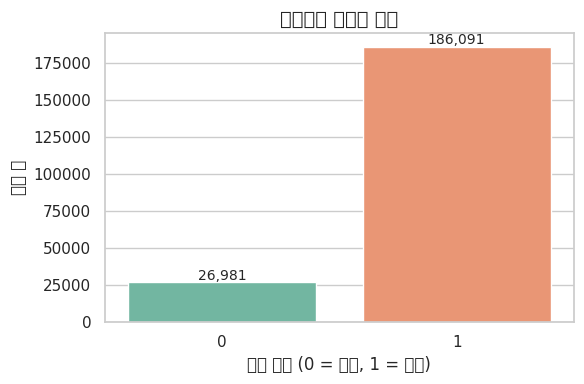

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 클래스 분포 계산
class_counts = classification_data["이탈여부"].value_counts().sort_index()

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")

plt.title("이탈여부 클래스 분포", fontsize=14)
plt.xlabel("이탈 여부 (0 = 유지, 1 = 이탈)", fontsize=12)
plt.ylabel("샘플 수", fontsize=12)

# 값 라벨 추가
for i, v in enumerate(class_counts.values):
    plt.text(i, v + max(class_counts.values)*0.01, f"{v:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# 모델 찾기

In [ ]:
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import classification_report, roc_auc_score
# import pandas as pd
# from imblearn.pipeline import Pipeline
# models = {
#     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     'LightGBM': LGBMClassifier(random_state=42)
# }

# results = []

# for name, model in models.items():
#     print(f"\n{name} 학습 중...")

#     pipe = Pipeline([
#         ('scaler', StandardScaler()),
#         ('smote', SMOTE(sampling_strategy=1/3, random_state=42)),
#         ('clf', model)
#     ])

#     pipe.fit(X_train, y_train)
#     print(f"{name} 학습 완료.")

#     y_pred = pipe.predict(X_test)
#     y_proba = pipe.predict_proba(X_test)[:, 1]

#     report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     auc = roc_auc_score(y_test, y_proba)

#     results.append({
#         'Model': name,
#         'Accuracy': report['accuracy'],
#         'Precision': report['1']['precision'],
#         'Recall': report['1']['recall'],
#         'F1-score': report['1']['f1-score'],
#         'ROC AUC': auc
#     })

#     print(f"{name} 결과 - AUC: {auc:.4f}, F1: {report['1']['f1-score']:.4f}")

# results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
# print("\n최종 비교 결과:")
# print(results_df)



XGBoost 학습 중...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:41:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 학습 완료.
XGBoost 결과 - AUC: 0.6768, F1: 0.1791

LightGBM 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 214385, number of negative: 643156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 857541, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098614
[LightGBM] [Info] Start training from score -1.098614
LightGBM 학습 완료.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM 결과 - AUC: 0.6910, F1: 0.1830

최종 비교 결과:
      Model  Accuracy  Precision    Recall  F1-score   ROC AUC
1  LightGBM  0.967786   0.223308  0.155051  0.183023  0.690955
0   XGBoost  0.957684   0.163265  0.198382  0.179119  0.676838


# 하이퍼파라미터

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, roc_auc_score
import numpy as np

# 하이퍼파라미터 후보
param_dist = {
    'clf__num_leaves': [15, 31, 50, 70],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__n_estimators': [100, 200, 300],
    'clf__min_child_samples': [10, 20, 30],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

# 클래스 비율 계산
count_1 = (y_train == 1).sum()
target_0 = int(count_1 * (1/2))  # label 0을 label 1의 1/5로 맞춤

# 파이프라인 정의
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy={0: target_0}, random_state=42)),
    ('clf', LGBMClassifier(random_state=42))
])
# RandomizedSearchCV (macro F1 기준 + 빠른 설정)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,                    # 줄여서 빠르게
    scoring=make_scorer(f1_score, average='macro'),  # label 0과 1 둘 다 평가
    cv=2,                         # 교차검증 fold 줄이기
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 학습
import time
start = time.time()
search.fit(X_train, y_train)
end = time.time()

# 최적 모델
best_model = search.best_estimator_
print("\nBest Params:", search.best_params_)
print(f"총 소요 시간: {end - start:.2f}초")

# 테스트셋 평가
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n최종 평가:")
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 156427, number of negative: 78213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 234640, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666668 -> initscore=0.693154
[LightGBM] [Info] Start training from score 0.693154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



최종 평가:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      3507
           1       0.97      1.00      0.98     39108

    accuracy                           0.97     42615
   macro avg       0.96      0.83      0.88     42615
weighted avg       0.97      0.97      0.97     42615

ROC AUC Score: 0.8912659310027354


# 테스트 코드들

In [ ]:
# import time
# from lightgbm import LGBMClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, roc_auc_score
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # 1. 데이터 분할
# X = classification_data.drop(columns=['visitorid', 'target_class'])
# y = classification_data['target_class']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # 2. 오버샘플링: label 0을 label 1의 1/3 수준으로 생성
# count_1 = (y_train == 1).sum()
# target_0 = int(count_1 * (1/5))  # 원하는 0의 수

# smote = SMOTE(sampling_strategy={0: target_0}, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # 3. 스케일링
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_resampled)
# X_test_scaled = scaler.transform(X_test)

# #clf__subsample': 1.0, 'clf__num_leaves': 50,
# #'clf__n_estimators': 300, 'clf__min_child_samples': 30, 'clf__max_depth': 10, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.6
# # 4. LGBMClassifier - 튜닝된 Best Params 적용
# model = LGBMClassifier(
#     subsample=1.0,
#     num_leaves=50,
#     n_estimators=300,
#     min_child_samples=30,
#     max_depth=10,
#     learning_rate=0.05,
#     colsample_bytree=0.6,
#     random_state=42
# )

# # 5. 학습
# start = time.time()
# model.fit(X_train_scaled, y_resampled)
# end = time.time()
# print(f"\n총 소요 시간: {end - start:.2f}초")

# # 6. 평가
# y_pred = model.predict(X_test_scaled)
# y_proba_model2 = model.predict_proba(X_test_scaled)[:, 1]

# print("\n📊 최종 평가:")
# print(classification_report(y_test, y_pred, zero_division=0))
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba_model2))

# # 7. Threshold 최적화 (label=0 기준 F1-score)
# print("\n📊 Threshold vs Precision/Recall/F1 for label=0")
# print("-" * 60)
# print(f"{'Threshold':<10} {'Precision(0)':<15} {'Recall(0)':<15} {'F1(0)':<10}")
# print("-" * 60)

# best_f1 = 0
# best_threshold = 0.5

# for t in np.arange(0.1, 0.91, 0.01):
#     y_pred = (y_proba < t).astype(int)
#     p = precision_score(y_test, y_pred, pos_label=0)
#     r = recall_score(y_test, y_pred, pos_label=0)
#     f1 = f1_score(y_test, y_pred, pos_label=0)
#     print(f"{t:<10.2f} {p:<15.3f} {r:<15.3f} {f1:<10.3f}")
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = t

# # 8. 최종 평가 결과 출력
# y_final_pred = (y_proba < best_threshold).astype(int)

# print(f"\n🔥 Best Threshold = {best_threshold:.2f} | F1(0) = {best_f1:.4f}")
# print("\n📋 최종 Classification Report (Best Threshold 적용)")
# print(classification_report(y_test, y_final_pred, zero_division=0))
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 643156, number of negative: 128631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 771787, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.833334 -> initscore=1.609439
[LightGBM] [Info] Start training from score 1.609439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

총 소요 시간: 28.52초


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 최종 평가:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      3831
           1       0.99      1.00      0.99    160789

    accuracy                           0.99    164620
   macro avg       0.92      0.81      0.86    164620
weighted avg       0.99      0.99      0.99    164620

ROC AUC Score: 0.8965911847203476

📊 Threshold vs Precision/Recall/F1 for label=0
------------------------------------------------------------
Threshold  Precision(0)    Recall(0)       F1(0)     
------------------------------------------------------------
0.10       0.011           0.446           0.021     
0.11       0.010           0.441           0.020     
0.12       0.010           0.437           0.020     
0.13       0.010           0.434           0.020     
0.14       0.010           0.431           0.020     
0.15       0.010           0.429           0.020     
0.16       0.010           0.425           0.020     
0.17       0.010           

In [ ]:
# import time
# import pandas as pd
# import numpy as np
# from lightgbm import LGBMClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
# from imblearn.over_sampling import SMOTE

# # 1. 데이터 분할
# X = classification_data.drop(columns=['visitorid', 'target_class'])
# y = classification_data['target_class']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # 2. 오버샘플링: label 0을 label 1의 1/5 수준으로 생성
# count_1 = (y_train == 1).sum()
# target_0 = int(count_1 * (1/5))
# smote = SMOTE(sampling_strategy={0: target_0}, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # 3. 스케일링
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_resampled)
# X_test_scaled = scaler.transform(X_test)

# # 4. LGBMClassifier - 튜닝된 Best Params 적용
# model = LGBMClassifier(
#     subsample=1.0,
#     num_leaves=50,
#     n_estimators=300,
#     min_child_samples=30,
#     max_depth=10,
#     learning_rate=0.05,
#     colsample_bytree=0.6,
#     random_state=42
# )

# # 5. 학습
# start = time.time()
# model.fit(X_train_scaled, y_resampled)
# end = time.time()
# print(f"\n⏱️ 총 소요 시간: {end - start:.2f}초")

# # 6. 예측 확률
# y_proba = model.predict_proba(X_test_scaled)[:, 1]

# # 7. Threshold 최적화 (label=0 기준 F1-score)
# print("\n📊 Threshold vs Precision/Recall/F1 for label=0")
# print("-" * 60)
# print(f"{'Threshold':<10} {'Precision(0)':<15} {'Recall(0)':<15} {'F1(0)':<10}")
# print("-" * 60)

# best_f1 = 0
# best_threshold = 0.5

# for t in np.arange(0.1, 0.91, 0.01):
#     y_pred = (y_proba < t).astype(int)
#     p = precision_score(y_test, y_pred, pos_label=0)
#     r = recall_score(y_test, y_pred, pos_label=0)
#     f1 = f1_score(y_test, y_pred, pos_label=0)
#     print(f"{t:<10.2f} {p:<15.3f} {r:<15.3f} {f1:<10.3f}")
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = t

# # 8. 최종 평가 결과 출력
# y_final_pred = (y_proba < best_threshold).astype(int)

# print(f"\n🔥 Best Threshold = {best_threshold:.2f} | F1(0) = {best_f1:.4f}")
# print("\n📋 최종 Classification Report (Best Threshold 적용)")
# print(classification_report(y_test, y_final_pred, zero_division=0))
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 643156, number of negative: 128631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 771787, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.833334 -> initscore=1.609439
[LightGBM] [Info] Start training from score 1.609439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

⏱️ 총 소요 시간: 28.32초


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Threshold vs Precision/Recall/F1 for label=0
------------------------------------------------------------
Threshold  Precision(0)    Recall(0)       F1(0)     
------------------------------------------------------------
0.10       0.011           0.446           0.021     
0.11       0.010           0.441           0.020     
0.12       0.010           0.437           0.020     
0.13       0.010           0.434           0.020     
0.14       0.010           0.431           0.020     
0.15       0.010           0.429           0.020     
0.16       0.010           0.425           0.020     
0.17       0.010           0.423           0.020     
0.18       0.010           0.421           0.019     
0.19       0.010           0.419           0.019     
0.20       0.010           0.416           0.019     
0.21       0.010           0.416           0.019     
0.22       0.010           0.414           0.019     
0.23       0.010           0.413           0.019     
0.24       0.010    

# 사용 코드 (학습)

In [ ]:
classification_data.shape

(52905, 10)

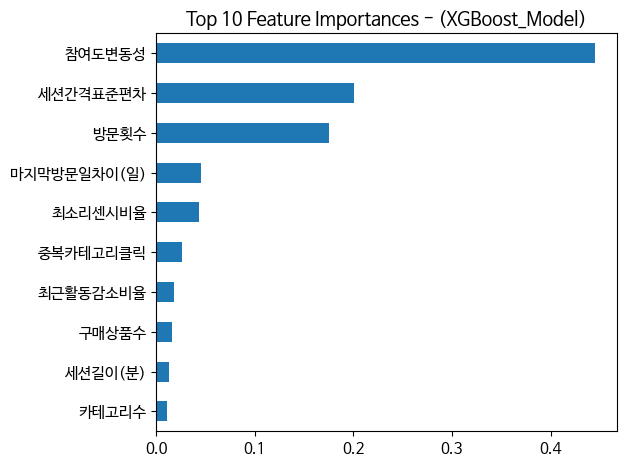

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# 내부 모델 접근
model = pipe.named_steps['clf']  # 'clf'는 pipeline 정의 시 사용한 이름

# 특성 중요도 추출 및 시각화
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances - (XGBoost_Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [6]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. 데이터 분할
X = classification_data.drop(columns=['방문자ID', '이탈여부'])
y = classification_data['이탈여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 오버샘플링 비율 계산 (label 0을 label 1과 같게)
count_1 = (y_train == 1).sum()
sampling_strategy = {0: count_1}

# 3. 파이프라인 정의
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=0.8,
        scale_pos_weight=5,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# 4. 학습
start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
print(f"\n⏱️ 총 소요 시간: {end - start:.2f}초")

# 5. 예측 및 평가
y_proba = pipe.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

print(f"\n📊 최종 평가 (threshold = {threshold}):")
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:35:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⏱️ 총 소요 시간: 11.40초

📊 최종 평가 (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      5396
           1       0.96      1.00      0.98     37219

    accuracy                           0.97     42615
   macro avg       0.97      0.87      0.91     42615
weighted avg       0.97      0.97      0.96     42615

ROC AUC Score: 0.9159820265046721


In [ ]:
import joblib

# 파이프라인 전체 저장
joblib.dump(pipe, "xgb_customer_churn_pipeline.pkl")
print("✅ 모델 저장 완료: xgb_customer_churn_pipeline.pkl")

✅ 모델 저장 완료: xgb_customer_churn_pipeline.pkl


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

# 1. 데이터 분할
X = classification_data.drop(columns=['방문자ID', '이탈여부'])
y = classification_data['이탈여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 오버샘플링 비율 계산 (1:1 맞춤)
count_1 = (y_train == 1).sum()
sampling_strategy = {0: count_1}

# 3. 파이프라인 정의
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# 4. 하이퍼파라미터 공간 정의
param_dist = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__scale_pos_weight': [1, 3, 5, 10]  # 클래스 불균형 보정
}

# 5. RandomizedSearchCV 설정
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 6. 학습
start = time.time()
search.fit(X_train, y_train)
end = time.time()
print(f"\n⏱️ 하이퍼파라미터 탐색 시간: {end - start:.2f}초")

# 7. 최적 모델로 예측 및 평가
best_model = search.best_estimator_
print("\n✅ Best Params:", search.best_params_)

y_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

print(f"\n📊 최종 평가 (threshold = {threshold}):")
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⏱️ 총 소요 시간: 15.40초

📊 최종 평가 (threshold = 0.3):
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      5396
           1       0.96      1.00      0.98     37219

    accuracy                           0.96     42615
   macro avg       0.98      0.86      0.91     42615
weighted avg       0.97      0.96      0.96     42615

ROC AUC Score: 0.9149889562372502


In [ ]:
classification_data.rename(columns={'세션ID': '방문횟수'}, inplace=True)

In [ ]:
classification_data

,Unnamed: 0,방문자ID,방문횟수,구매상품수,카테고리수,총지출액,세션길이(분),마지막방문일차이(일),이탈여부,최근활동감소비율,참여도변동성,세션간격표준편차,최소리센시비율,중복카테고리클릭
0,0,7,1,2.0,1.0,30000.0,3.101067,1,0,0.0,2.192785,0.0,0.999990,0.250000
1,1,16,1,1.0,1.0,28800.0,0.000000,3,1,0.0,0.000000,0.0,0.999997,0.000000
2,2,34,1,1.0,1.0,36840.0,0.000000,1,1,0.0,0.000000,0.0,0.999990,0.000000
3,3,44,1,1.0,1.0,22920.0,0.000000,3,1,0.0,0.000000,0.0,0.999997,0.000000
4,4,58,1,1.0,1.0,1284720.0,0.703850,4,1,0.0,0.000000,0.0,0.999998,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51154,52900,1407484,1,1.0,1.0,69120.0,6.389483,1,1,0.0,0.000000,0.0,0.999990,0.666667
51155,52901,1407497,1,1.0,1.0,126000.0,0.000000,0,0,0.0,2.009421,0.0,0.000000,0.250000
51156,52902,1407545,1,1.0,1.0,688680.0,0.000000,2,1,0.0,0.000000,0.0,0.999995,0.000000
51157,52903,1407568,1,1.0,1.0,143400.0,0.000000,5,1,0.0,0.000000,0.0,0.999998,0.000000


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


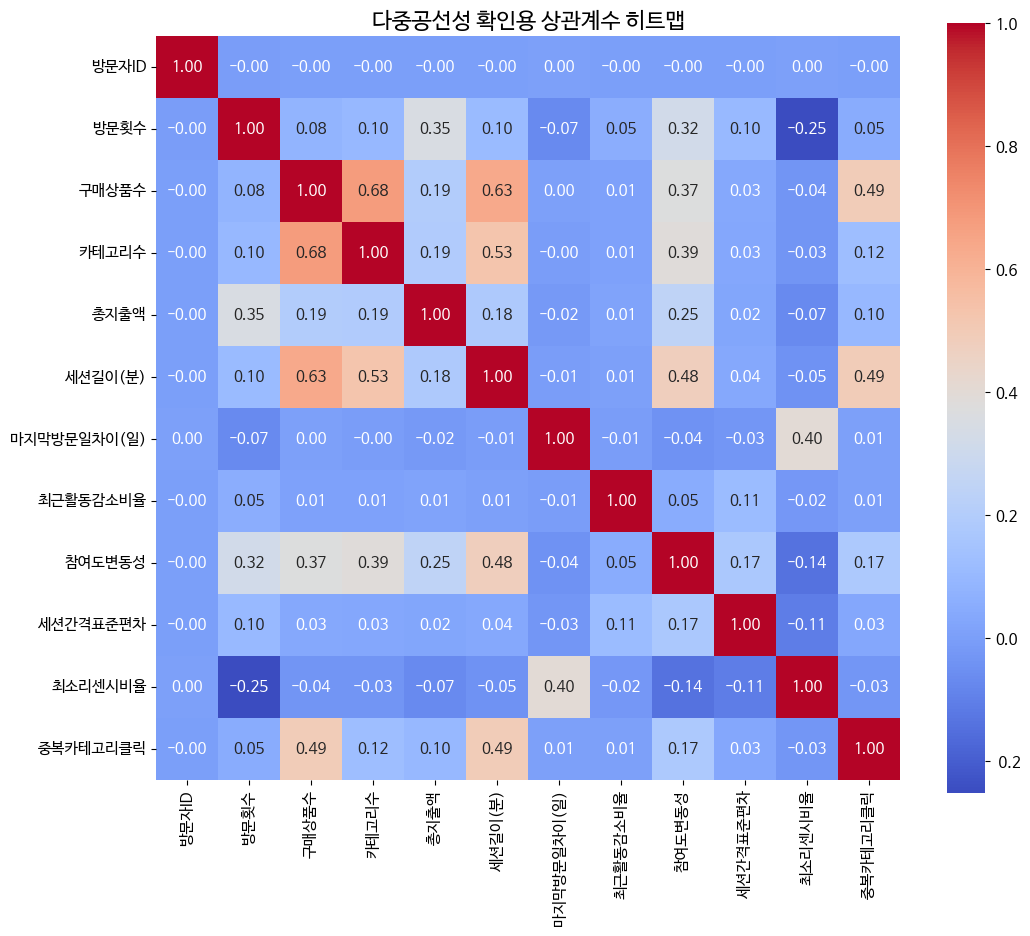

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
corr_matrix = classification_data.drop(columns=['이탈여부'], errors='ignore').corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("다중공선성 확인용 상관계수 히트맵", fontsize=16)
plt.show()


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 타겟 컬럼 제외
X_vif = classification_data.drop(columns=['이탈여부'], errors='ignore')
X_vif_const = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif_const.values, i+1) for i in range(X_vif.shape[1])]
vif_df.sort_values("VIF", ascending=False, inplace=True)

print("📋 다중공선성(VIF) 결과:")
print(vif_df)

📋 다중공선성(VIF) 결과:
        Feature       VIF
2         구매상품수  2.851130
3         카테고리수  2.306925
5       세션길이(분)  2.188496
11     중복카테고리클릭  1.703183
8        참여도변동성  1.531663
1          방문횟수  1.300215
10      최소리센시비율  1.279714
4          총지출액  1.195721
6   마지막방문일차이(일)  1.190924
9      세션간격표준편차  1.054741
7      최근활동감소비율  1.015368
0         방문자ID  1.000048


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. 예측
y_train_pred = pipe.predict()

# 2. Classification Report
print("📋 [Train 데이터 기준] Classification Report")
print(classification_report(y_resampled, y_train_pred, zero_division=0))

# 3. Confusion Matrix 시각화
labels = ["유지자 (0)", "이탈자 (1)"]
cm = confusion_matrix(y_resampled, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("📊 Confusion Matrix (Train Data)")
plt.show()


NameError: name 'X_train_scaled' is not defined

In [1]:
!pip install flaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 5.8 MB/s eta 0:00:00


In [2]:
pip install imbalanced-learn flaml

In [3]:
pip install numpy==1.24.4 --upgrade

In [3]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from flaml import AutoML
# 1. 데이터 분할
X = classification_data.drop(columns=['방문자ID', '이탈여부'])
y = classification_data['이탈여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 오버샘플링 (label 0을 label 1과 같은 수로 증강)
count_1 = (y_train == 1).sum()
smote = SMOTE(sampling_strategy={0: count_1}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 3. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [8]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from flaml import AutoML
# classification_data = pd.read_csv('/content/drive/MyDrive/filtered_data.csv')
# 1. 데이터 분할
X = classification_data.drop(columns=['방문자ID', '이탈여부'])
y = classification_data['이탈여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 오버샘플링 (label 0을 label 1과 같은 수로 증강)
count_1 = (y_train == 1).sum()
smote = SMOTE(sampling_strategy={0: count_1}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 3. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 4. AutoML 모델 설정 및 학습
automl = AutoML()
start = time.time()
automl.fit(
    X_train_scaled, y_resampled,
    task="classification",
    time_budget= 700 * 2,          # 5분 예산
    ensemble=True,
    metric='f1',              # 클래스 불균형에 강한 지표
    log_file_name='flaml_classification.log',
    verbose=1
)
end = time.time()

# 5. 예측 및 평가
y_pred = automl.predict(X_test_scaled)
y_proba = automl.predict_proba(X_test_scaled)[:, 1]

print(f"\n⏱️ 총 소요 시간: {end - start:.2f}초")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


⏱️ 총 소요 시간: 1876.54초

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      5396
           1       0.97      0.99      0.98     37219

    accuracy                           0.96     42615
   macro avg       0.95      0.88      0.91     42615
weighted avg       0.96      0.96      0.96     42615

ROC AUC Score: 0.9138530065797117


In [9]:
import joblib

# 모델 저장
joblib.dump(automl, 'automl_model.pkl')

['automl_model.pkl']

In [14]:
automl = joblib.load('automl_model.pkl')

In [8]:
!pip install --upgrade flaml
from flaml.automl.data import get_output_from_log

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from flaml import AutoML
import joblib
# 2. 데이터 분할
X = classification_data.drop(columns=['방문자ID', '이탈여부'])
y = classification_data['이탈여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. 오버샘플링
count_1 = (y_train == 1).sum()
smote = SMOTE(sampling_strategy={0: count_1}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 5. AutoML 학습
automl = AutoML()
automl.fit(
    X_train_scaled, y_train_resampled,
    task="classification",
    time_budget=600,
    log_file_name="flaml_classification.log",
    metric="f1",
    verbose=1,
    ensemble=True,
)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

TypeError: list indices must be integers or slices, not LGBMEstimator

In [35]:
# 7. 모델별 재학습 및 평가
results = []

for learner_name, config in automl.best_config_per_estimator.items():
    print(f"🔄 {learner_name} 모델 개별 재학습 중...")

    clf = AutoML()
    clf.fit(
        X_train_scaled, y_train_resampled,
        estimator_list=[learner_name],
        time_budget=60,  # 필요시 조절
        metric='f1',
        task='classification',
        custom_hp=config
    )

    # 예측
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # 결과 저장
    results.append({
        'Model': learner_name,
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'F1 (0)': report['0']['f1-score'],
        'F1 (1)': report['1']['f1-score'],
        'Best Params': config
    })

    joblib.dump(clf.model, f"{learner_name}_model.pkl")

# 8. 결과 출력
results_df = pd.DataFrame(results).sort_values(by='F1 (1)', ascending=False)
from IPython.display import display
display(results_df)

# 전체 모델 및 스케일러 저장
joblib.dump(automl, "automl_full_model.pkl")
joblib.dump(scaler, "scaler.pkl")

🔄 lgbm 모델 개별 재학습 중...
[flaml.automl.logger: 04-18 03:28:15] {1728} INFO - task = classification
[flaml.automl.logger: 04-18 03:28:15] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-18 03:28:16] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 04-18 03:28:16] {1955} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 04-18 03:28:16] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-18 03:28:16] {2393} INFO - Estimated sufficient time budget=40426s. Estimated necessary time budget=40s.
[flaml.automl.logger: 04-18 03:28:16] {2442} INFO -  at 1.0s,	estimator lgbm's best error=0.1109,	best estimator lgbm's best error=0.1109
[flaml.automl.logger: 04-18 03:28:16] {2258} INFO - iteration 1, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:16] {2442} INFO -  at 1.1s,	estimator lgbm's best error=0.1109,	best estimator lgbm's best error=0.1109
[flaml.automl.logger: 04-18 03:28:16] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 04-18 03:28:16] {2442} INFO -  at 1.2s,	estimator lgbm's best error=0.0914,	best estimator lgbm's best error=0.0914
[flaml.automl.logger: 04-18 03:28:16] {2258} INFO - iteration 3, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:17] {2442} INFO -  at 1.5s,	estimator lgbm's best error=0.0749,	best estimator lgbm's best error=0.0749
[flaml.automl.logger: 04-18 03:28:17] {2258} INFO - iteration 4, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:17] {2442} INFO -  at 1.8s,	estimator lgbm's best error=0.0749,	best estimator lgbm's best error=0.0749
[flaml.automl.logger: 04-18 03:28:17] {2258} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 04-18 03:28:17] {2442} INFO -  at 1.9s,	estimator lgbm's best error=0.0704,	best estimator lgbm's best error=0.0704
[flaml.automl.logger: 04-18 03:28:17] {2258} INFO - iteration 6, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:17] {2442} INFO -  at 2.1s,	estimator lgbm's best error=0.0704,	best estimator lgbm's best error=0.0704
[flaml.automl.logger: 04-18 03:28:17] {2258} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 04-18 03:28:17] {2442} INFO -  at 2.2s,	estimator lgbm's best error=0.0704,	best estimator lgbm's best error=0.0704
[flaml.automl.logger: 04-18 03:28:17] {2258} INFO - iteration 8, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:18] {2442} INFO -  at 2.4s,	estimator lgbm's best error=0.0600,	best estimator lgbm's best error=0.0600
[flaml.automl.logger: 04-18 03:28:18] {2258} INFO - iteration 9, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:18] {2442} INFO -  at 2.6s,	estimator lgbm's best error=0.0600,	best estimator lgbm's best error=0.0600
[flaml.automl.logger: 04-18 03:28:18] {2258} INFO - iteration 10, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:19] {2442} INFO -  at 3.6s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl.logger: 04-18 03:28:19] {2258} INFO - iteration 11, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:20] {2442} INFO -  at 4.7s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl.logger: 04-18 03:28:20] {2258} INFO - iteration 12, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:21] {2442} INFO -  at 5.4s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl.logger: 04-18 03:28:21] {2258} INFO - iteration 13, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:22] {2442} INFO -  at 6.8s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl.logger: 04-18 03:28:22] {2258} INFO - iteration 14, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:23] {2442} INFO -  at 8.1s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl.logger: 04-18 03:28:23] {2258} INFO - iteration 15, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:28] {2442} INFO -  at 12.5s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:28] {2258} INFO - iteration 16, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:31] {2442} INFO -  at 15.6s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:31] {2258} INFO - iteration 17, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:33] {2442} INFO -  at 17.8s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:33] {2258} INFO - iteration 18, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:36] {2442} INFO -  at 20.9s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:36] {2258} INFO - iteration 19, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:37] {2442} INFO -  at 22.0s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:37] {2258} INFO - iteration 20, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:38] {2442} INFO -  at 22.4s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:38] {2258} INFO - iteration 21, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:41] {2442} INFO -  at 25.5s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:41] {2258} INFO - iteration 22, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:43] {2442} INFO -  at 28.1s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:43] {2258} INFO - iteration 23, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:45] {2442} INFO -  at 29.9s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:45] {2258} INFO - iteration 24, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:48] {2442} INFO -  at 32.6s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:48] {2258} INFO - iteration 25, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:50] {2442} INFO -  at 35.1s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:50] {2258} INFO - iteration 26, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:53] {2442} INFO -  at 37.7s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:53] {2258} INFO - iteration 27, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:28:55] {2442} INFO -  at 39.3s,	estimator lgbm's best error=0.0257,	best estimator lgbm's best error=0.0257
[flaml.automl.logger: 04-18 03:28:55] {2258} INFO - iteration 28, current learner lgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:29:11] {2442} INFO -  at 55.4s,	estimator lgbm's best error=0.0250,	best estimator lgbm's best error=0.0250


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 04-18 03:29:26] {2685} INFO - retrain lgbm for 15.6s
[flaml.automl.logger: 04-18 03:29:26] {2688} INFO - retrained model: LGBMClassifier(colsample_bytree=0.5178642845063358,
               learning_rate=0.05646061409019466, max_bin=127,
               min_child_samples=3, n_estimators=399, n_jobs=-1, num_leaves=45,
               reg_alpha=0.0009765625, reg_lambda=0.01039649327225154,
               verbose=-1)
[flaml.automl.logger: 04-18 03:29:26] {1985} INFO - fit succeeded
[flaml.automl.logger: 04-18 03:29:26] {1986} INFO - Time taken to find the best model: 55.4465548992157


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 rf 모델 개별 재학습 중...
[flaml.automl.logger: 04-18 03:29:28] {1728} INFO - task = classification
[flaml.automl.logger: 04-18 03:29:28] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-18 03:29:28] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 04-18 03:29:28] {1955} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 04-18 03:29:28] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 04-18 03:29:28] {2393} INFO - Estimated sufficient time budget=20629s. Estimated necessary time budget=21s.
[flaml.automl.logger: 04-18 03:29:28] {2442} INFO -  at 0.3s,	estimator rf's best error=0.1276,	best estimator rf's best error=0.1276
[flaml.automl.logger: 04-18 03:29:28] {2258} INFO - iteration 1, current learner rf
[flaml.automl.logger: 04-18 03:29:28] {2442} INFO -  at 0.4s,	estimator rf's best error=0.0893,	best estimator rf's best error=0.0893
[flaml.automl.logger: 04-18 03:29:28] {2258} INFO - iteration 2, current learner rf
[

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 04-18 03:34:40] {2393} INFO - Estimated sufficient time budget=32477s. Estimated necessary time budget=32s.
[flaml.automl.logger: 04-18 03:34:40] {2442} INFO -  at 0.4s,	estimator sgd's best error=0.2132,	best estimator sgd's best error=0.2132
[flaml.automl.logger: 04-18 03:34:40] {2258} INFO - iteration 1, current learner sgd
[flaml.automl.logger: 04-18 03:34:40] {2442} INFO -  at 0.5s,	estimator sgd's best error=0.2077,	best estimator sgd's best error=0.2077
[flaml.automl.logger: 04-18 03:34:40] {2258} INFO - iteration 2, current learner sgd
[flaml.automl.logger: 04-18 03:34:41] {2442} INFO -  at 0.9s,	estimator sgd's best error=0.2077,	best estimator sgd's best error=0.2077
[flaml.automl.logger: 04-18 03:34:41] {2258} INFO - iteration 3, current learner sgd
[flaml.automl.logger: 04-18 03:34:41] {2442} INFO -  at 1.1s,	estimator sgd's best error=0.2077,	best estimator sgd's best error=0.2077
[flaml.automl.logger: 04-18 03:34:41] {2258} INFO - iteration 4, curren

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 04-18 03:35:42] {2393} INFO - Estimated sufficient time budget=102595s. Estimated necessary time budget=103s.
[flaml.automl.logger: 04-18 03:35:42] {2442} INFO -  at 0.7s,	estimator lrl1's best error=0.1929,	best estimator lrl1's best error=0.1929
[flaml.automl.logger: 04-18 03:35:42] {2258} INFO - iteration 1, current learner lrl1
[flaml.automl.logger: 04-18 03:35:42] {2442} INFO -  at 1.1s,	estimator lrl1's best error=0.1929,	best estimator lrl1's best error=0.1929
[flaml.automl.logger: 04-18 03:35:42] {2258} INFO - iteration 2, current learner lrl1
[flaml.automl.logger: 04-18 03:35:43] {2442} INFO -  at 1.6s,	estimator lrl1's best error=0.1929,	best estimator lrl1's best error=0.1929
[flaml.automl.logger: 04-18 03:35:43] {2258} INFO - iteration 3, current learner lrl1
[flaml.automl.logger: 04-18 03:35:45] {2442} INFO -  at 3.8s,	estimator lrl1's best error=0.1817,	best estimator lrl1's best error=0.1817
[flaml.automl.logger: 04-18 03:35:45] {2258} INFO - iterat

,Model,ROC AUC,F1 (0),F1 (1),Best Params
0,lgbm,0.915907,0.847917,0.980695,"{'n_estimators': 500, 'num_leaves': 109, 'min_..."
1,rf,0.915445,0.845626,0.980345,"{'n_estimators': 40, 'max_features': 0.8184227..."
2,xgboost,0.907278,0.840473,0.979429,"{'n_estimators': 107, 'max_leaves': 1767, 'min..."
3,extra_tree,0.914621,0.837763,0.979055,"{'n_estimators': 9, 'max_features': 1.0, 'max_..."
4,xgb_limitdepth,0.904701,0.830469,0.977890,None
6,lrl1,0.857387,0.620156,0.938377,None
5,sgd,0.833324,0.439187,0.846641,"{'penalty': 'None', 'alpha': 0.001477658978070..."


['scaler.pkl']

In [26]:
import flaml
import inspect

print("✅ FLAML version:", flaml.__version__)

# get_estimator_from_log 존재 여부 확인
try:
    from flaml.automl.model import get_estimator_from_log
    print("✅ 'get_estimator_from_log' found in flaml.automl.model")
    print(inspect.getsource(get_estimator_from_log))
except ImportError:
    print("❌ 'get_estimator_from_log' not found in flaml.automl.model")


✅ FLAML version: 2.3.4
❌ 'get_estimator_from_log' not found in flaml.automl.model


In [11]:
 def get_estimator_from_log(self, log_file_name: str, record_id: int, task: str | Task):
        """Get the estimator from log file.

        Args:
            log_file_name: A string of the log file name.
            record_id: An integer of the record ID in the file,
                0 corresponds to the first trial.
            task: A string of the task type,
                'binary', 'multiclass', 'regression', 'ts_forecast', 'rank',
                or an instance of the Task class.

        Returns:
            An estimator object for the given configuration.
        """

        with training_log_reader(log_file_name) as reader:
            record = reader.get_record(record_id)
            estimator = record.learner
            config = AutoMLState.sanitize(record.config)

        if isinstance(task, str):
            task = task_factory(task)

        estimator, _ = train_estimator(
            X_train=None,
            y_train=None,
            config_dic=config,
            task=task,
            estimator_name=estimator,
            estimator_class=self._state.learner_classes.get(estimator),
            eval_metric="train_time",
        )
        return estimator


NameError: name 'Task' is not defined

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import joblib

# 학습한 모델과 스케일러 저장
joblib.dump(pipe, "saved_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ----------------------------
# Load model, scaler, and data
# ----------------------------
model = joblib.load("saved_model.pkl")
scaler = joblib.load("scaler.pkl")
data = pd.read_csv("classification_data.csv")
# ✅ 불필요한 인덱스 컬럼 제거
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])
# ----------------------------
# Preprocess
# ----------------------------
X = data.drop(columns=['방문자ID', '이탈여부'])
y = data['이탈여부']

# KPI metrics
total_users = len(data)
churned_users = y.sum()
active_users = total_users - churned_users
churn_rate = churned_users / total_users

# ----------------------------
# Streamlit Layout
# ----------------------------
st.set_page_config(layout="wide")
st.title("📊 이커머스 고객 이탈 현황 및 예측")

# Top KPIs
col1, col2, col3, col4 = st.columns(4)
col1.metric("총 고객 수", f"{total_users:,}명")
col2.metric("이탈 고객 수", f"{churned_users:,}명")
col3.metric("이탈률", f"{churn_rate*100:.2f}%")
col4.metric("활성 고객 수", f"{active_users:,}명")

# 🔄 이탈자 도넛 차트
st.subheader("🌀 이탈자 / 비이탈자 비율")
churn_dist = data['이탈여부'].value_counts()
labels = ['비이탈자', '이탈자']
fig1, ax1 = plt.subplots()
ax1.pie(churn_dist, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis("equal")
st.pyplot(fig1)

# 연령대 대신 "마지막방문일차이(일)" 기준 가상 활동기간 구간
st.subheader("📈 마지막 방문일 기준 이탈률")
data['최근방문_기준구간'] = pd.cut(data['마지막방문일차이(일)'],
                            bins=[-1, 7, 30, 60, 90, np.inf],
                            labels=['7일↓', '1달↓', '2달↓', '3달↓', '3달↑'])
fig2, ax2 = plt.subplots()
sns.barplot(
    x='최근방문_기준구간', y='이탈여부', data=data, estimator=np.mean, ci=None, ax=ax2
)
ax2.set_ylabel("이탈률")
st.pyplot(fig2)

# 상위 5% 지출 고객 이탈 분석
st.subheader("💸 상위 고객 이탈 분석")
top_5_cut = np.percentile(data['총지출액'], 95)
top_users = data[data['총지출액'] >= top_5_cut]
top_churn_rate = top_users['이탈여부'].mean()
st.metric("상위 5% 고객 중 이탈률", f"{top_churn_rate*100:.2f}%")

fig3, ax3 = plt.subplots()
sns.scatterplot(
    data=top_users,
    x='총지출액', y='세션길이(분)', hue='이탈여부', style='이탈여부', ax=ax3
)
ax3.set_title("상위 고객 분포")
st.pyplot(fig3)

# 주요 지표 비교
st.subheader("📋 주요 지표 비교 (이탈 vs 비이탈)")
compare_cols = ['총지출액', '구매상품수', '최근활동감소비율', '중복카테고리클릭']
compare_df = data.groupby('이탈여부')[compare_cols].mean().T
compare_df.columns = ['비이탈자', '이탈자']
st.dataframe(compare_df)

# 혼동 행렬
st.subheader("📌 혼동 행렬")
X_scaled = scaler.transform(X)
y_pred = model.predict(X_scaled)
cm = confusion_matrix(y, y_pred)
fig4, ax4 = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_xlabel("예측값")
ax4.set_ylabel("실제값")
st.pyplot(fig4)

# 예측 시뮬레이션
st.sidebar.header("🤖 고객 이탈 예측 시뮬레이션")
input_data = {}
for col in X.columns:
    val = st.sidebar.number_input(col, float(data[col].min()), float(data[col].max()), float(data[col].mean()))
    input_data[col] = val
input_df = pd.DataFrame([input_data])
input_scaled = scaler.transform(input_df)
pred = model.predict(input_scaled)[0]
proba = model.predict_proba(input_scaled)[0][1]

st.sidebar.markdown("---")
st.sidebar.metric("📉 이탈 확률", f"{proba*100:.2f}%")
if pred == 1:
    st.sidebar.error("❌ 이탈 가능성 높음")
else:
    st.sidebar.success("✅ 유지 가능성 높음")


2025-04-17 11:22:15.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.244 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.253 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 11:22:15.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!pkill -f ngrok

In [ ]:
from pyngrok import conf

# 올바른 토큰만 등록
conf.get_default().auth_token = "2tykzpIQbYdJdhVfUHBNHUDiL1R_57GD9CFEE6CWBXoxqdbVT"

In [ ]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null &

# Ngrok 터널 열기
public_url = ngrok.connect(addr="8501")
print(f"🌐 Streamlit 앱 외부 접속 URL: {public_url}")


🌐 Streamlit 앱 외부 접속 URL: NgrokTunnel: "https://4393-34-86-222-139.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8509
  Network URL: http://172.28.0.12:8509
  External URL: http://34.86.222.139:8509

  Stopping...
^C


In [ ]:
from pyngrok import ngrok
ngrok.kill()

In [ ]:
code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams

# ----------------------------
# Config
# ----------------------------
st.set_page_config(layout="wide", page_title="이커머스 고객 이탈 예측")
plt.rcParams['font.family'] = 'NanumGothic'
sns.set_style("whitegrid")

# ----------------------------
# Load model, scaler, data
# ----------------------------
@st.cache_resource
def load_model():
    return joblib.load("saved_model.pkl"), joblib.load("scaler.pkl")

@st.cache_data
def load_data():
    df = pd.read_csv("classification_data.csv")
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

model, scaler = load_model()
data = load_data()

# ----------------------------
# Preprocessing
# ----------------------------
X = data.drop(columns=['방문자ID', '이탈여부'])
y = data['이탈여부']
X_scaled = scaler.transform(X)
y_pred = model.predict(X_scaled)

# ----------------------------
# Main UI
# ----------------------------
st.markdown("""
    <style>
        .block-container { padding: 1.5rem 2rem; }
        .st-emotion-cache-z5fcl4 { background-color: #222 !important; color: #fff !important; }
        .st-emotion-cache-1v0mbdj.e115fcil2 { background-color: #111; padding: 1.2em; border-radius: 0.5rem; }
        .st-emotion-cache-1kyxreq { color: #ddd !important; }
        .st-emotion-cache-1r6slb0 { background-color: #1e1e1e; }
    </style>
""", unsafe_allow_html=True)

st.title("💡 이커머스 고객 이탈 예측 대시보드")

# ----------------------------
# Top KPIs
# ----------------------------
total_users = len(data)
churned = y.sum()
active = total_users - churned
churn_rate = churned / total_users
col1, col2, col3, col4 = st.columns(4)
col1.metric("총 고객 수", f"{total_users:,}명")
col2.metric("이탈 고객 수", f"{churned:,}명")
col3.metric("이탈률", f"{churn_rate*100:.2f}%")
col4.metric("활성 고객 수", f"{active:,}명")

# ----------------------------
# 4x2 그래프 대시보드
# ----------------------------
figures = []

# 그래프 1 - 이탈자 분포
def fig_churn_ratio():
    fig, ax = plt.subplots()
    dist = y.value_counts()
    ax.pie(dist, labels=['비이탈자', '이탈자'], autopct='%1.1f%%', startangle=90)
    ax.axis("equal")
    ax.set_title("이탈자 / 비이탈자 비율")
    return fig

# 그래프 2 - 총지출액 상위 고객 분포
def fig_top_spenders():
    top5 = np.percentile(data['총지출액'], 95)
    top = data[data['총지출액'] >= top5]
    fig, ax = plt.subplots()
    sns.scatterplot(data=top, x='총지출액', y='세션길이(분)', hue='이탈여부', ax=ax)
    ax.set_title("상위 고객 이탈 분포")
    return fig

# 그래프 3 - 최근방문 기준 구간별 이탈률
def fig_recent_ratio():
    data['최근방문_구간'] = pd.cut(data['마지막방문일차이(일)'], [-1, 7, 30, 60, 90, np.inf], labels=['7일↓','1달↓','2달↓','3달↓','3달↑'])
    fig, ax = plt.subplots()
    sns.barplot(x='최근방문_구간', y='이탈여부', data=data, estimator=np.mean, ax=ax)
    ax.set_ylabel("이탈률")
    ax.set_title("최근 방문 구간별 이탈률")
    return fig

# 그래프 4 - 세션길이 Boxplot

def fig_session_box():
    fig, ax = plt.subplots()
    sns.boxplot(x='이탈여부', y='세션길이(분)', data=data, ax=ax)
    ax.set_title("세션 길이 분포")
    return fig

# 그래프 5 - 총지출액 KDE

def fig_spend_kde():
    fig, ax = plt.subplots()
    for label in [0, 1]:
        sns.kdeplot(data[data['이탈여부'] == label]['총지출액'], label=f"{'비이탈자' if label==0 else '이탈자'}", ax=ax)
    ax.set_title("총지출액 밀도 분포")
    ax.legend()
    return fig

# 그래프 6 - confusion matrix

def fig_confusion():
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title("혼동 행렬")
    return fig

# 그래프 7 - 활동감소비율별 이탈률

def fig_decay():
    fig, ax = plt.subplots()
    sns.boxplot(x='이탈여부', y='최근활동감소비율', data=data, ax=ax)
    ax.set_title("최근 활동감소비율 분포")
    return fig

# 그래프 8 - 구매상품수 분포

def fig_item():
    fig, ax = plt.subplots()
    sns.violinplot(x='이탈여부', y='구매상품수', data=data, ax=ax)
    ax.set_title("구매 상품 수 분포")
    return fig

# 그래프 리스트
figures = [
    fig_churn_ratio(), fig_top_spenders(),
    fig_recent_ratio(), fig_session_box(),
    fig_spend_kde(), fig_confusion(),
    fig_decay(), fig_item()
]

# ----------------------------
# Layout - 4x2 display
# ----------------------------
for i in range(0, len(figures), 4):
    cols = st.columns(4)
    for j in range(4):
        if i + j < len(figures):
            with cols[j]:
                st.pyplot(figures[i + j])

'''

with open("app.py", "w") as f:
    f.write(code)


In [ ]:
# 1. 나눔고딕 글꼴 설치
!apt-get -qq install fonts-nanum

# 2. matplotlib에 글꼴 적용
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'NanumGothicCoding'

# 3. 글꼴 캐시 리셋 (선택)
import matplotlib.font_manager as fm
fm._rebuild()

# 🔁 이후 matplotlib/seaborn 그래프는 이제 한글이 깨지지 않음!


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'